<img src="https://upload.wikimedia.org/wikipedia/commons/6/6e/St%C3%B6wer_Titanic.jpg" width="520">

# Titanic Survival: Seaborn and Ensembles
**My second Titanic kernel**

**[Part 0: Imports, Functions](#Part-0:-Imports,-Functions)** 

**[Part 1: Exploratory Data Analysis](#Part-1:-Exploratory-Data-Analysis)** 

* Seaborn [heatmaps](#Seaborn-heatmaps) : missing data in df_train and df_test
* Seaborn [countplots](#Seaborn-Countplots) : Number of (Non-)Survivors as function of features
* Seaborn [distplots](#Seaborn-Distplots) : Distribution of Age and Fare as function of Pclass, Sex and Survived  
* [Bar and Box plots](#Bar-and-Box-plots) for categorical features : Pclass and Embarked
* Seaborn [violin and swarm plots](#Swarm-and-Violin-plots) : Survivals as function of Age, Pclass and Sex

**[Part 2: Data Wrangling and Feature Engineering](#Part-2:-Data-Wrangling-and-Feature-Engineering)**  

* [Feature Engineering](#Feature-Engineering): include new features to improve the performance of the classifiers and to fill missing values:  
Family size, Alone, Name length, Title
* [Data Wrangling](#Data-Wrangling): fill NaN, convert categorical to numerical, [Standard Scaler](#Standard-Scaler), create X, y and X_test for Part 3


**[Part 3: Optimization of Classifier parameters, Boosting, Voting and Stacking](#Part-3:-Optimization-of-Classifier-parameters,-Boosting,-Voting-and-Stacking)**  

* Review: [k fold cross validation](#Review:-k-fold-cross-validation) for SVC and Random Forest: 
 * SVC, features not scaled 
 * SVC, features scaled 
 * Random Forest Classifier, RFC, features not scaled 
* Hyperparameter tuning with GridSearchCV and RandomizedSearchCV for: 
 * Support Vector Machine Classifier, [SVC](#SVC-:-RandomizedSearchCV) 
 * K Nearest Neighbor, [KNN](#KNN)
 * [Decision Tree](#Decision-Tree)
 * [Random Forest Classifier](#Random-Forest), RFC

* study Ensemble models like Boosting, Stacking and Voting:  
 * [ExtraTreesClassifier](#ExtraTreesClassifier)
 * Gradient Boost Decision Tree - [GBDT](#Gradient-Boost-Decision-Tree-GBDT)
 * eXtreme Gradient Boosting - [XGBoost](#eXtreme-Gradient-Boosting---XGBoost)   
 * Adaptive Boosting - [AdaBoost](#Ada-Boost)
 * [CatBoost](#CatBoost)
 * lightgbm [LGBM](#lightgbm-LGBM)
 * Voting: [VotingClassifier 1](#First-Voting), [VotingClassifier 2](#Second-Voting)  
 * Stacking : [StackingClassifier](#StackingClassifier)  
* Compare Classifier performance based on the validation score : [comparison plot](#Comparison-plot-for-best-models)
* Correlation of prediction results : [correlation matrix](#Correlation-of-prediction-results)

* **TODO:**  
 
compare feature importances  
complete documentation

**References**  
While this notebook contains some work work based on my ideas, it is also a collection of approaches  
and techniques from these kaggle notebooks:

# Part 0: Imports, Functions

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# plotly library
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
#warnings.filterwarnings("ignore")
#warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)
#warnings.filterwarnings(action='once')

from sklearn.utils._testing import ignore_warnings

from subprocess import check_output
print(check_output(["ls", "input"]).decode("utf8"))

gender_submission.csv
test.csv
train.csv



In [69]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

**some useful functions**

In [70]:
def get_best_score(model):
    
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
    
    return model.best_score_


def plot_feature_importances(model, columns):
    nr_f = 10
    imp = pd.Series(data = model.best_estimator_.feature_importances_, 
                    index=columns).sort_values(ascending=False)
    plt.figure(figsize=(7,5))
    plt.title("Feature importance")
    ax = sns.barplot(y=imp.index[:nr_f], x=imp.values[:nr_f], orient='h')

**loading the data**

In [71]:
df_train = pd.read_csv("input/train.csv")
df_test = pd.read_csv("input/test.csv")

# Part 1: Exploratory Data Analysis

In [72]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [73]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [76]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [77]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Looks like the feature Cabin has lots of missing data, also some data for Age and Embarked is missing.  
Lets plot the seaborn heatmap of the isnull matrix for the train and test data

### Seaborn heatmaps  
missing data in df_train and df_test

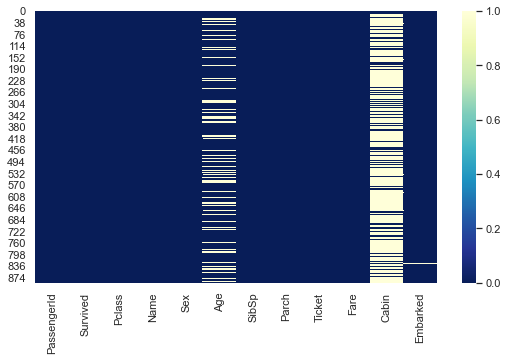

In [80]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(df_train.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

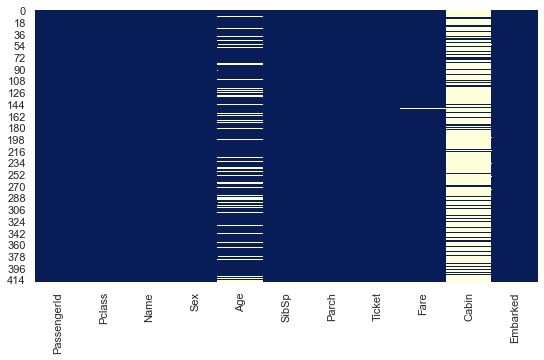

In [79]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(df_test.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

### Seaborn Countplots  
for all categorical columns

In [81]:
cols = ['Survived', 'Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked']

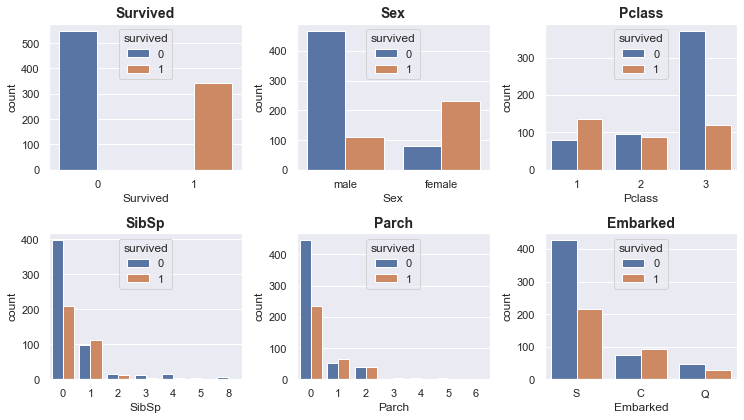

In [82]:
nr_rows = 2
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        
        i = r*nr_cols+c       
        ax = axs[r][c]
        sns.countplot(df_train[cols[i]], hue=df_train["Survived"], ax=ax)
        ax.set_title(cols[i], fontsize=14, fontweight='bold')
        ax.legend(title="survived", loc='upper center') 
        
plt.tight_layout()   

Of the 891 passengers in df_test, less than 350 survive.  
Much more women survive than men.  
Also, the chance to survive is much higher in Pclass 1 and 2 than in Class 3.  
Survival rate for passengers travelling with SibSp or Parch is higher than for those travelling alone.  
Passengers embarked in C and Q are more likely to survie than those embarked in S.

### Seaborn Distplots 
**Distribution of Age as function of Pclass, Sex and Survived**

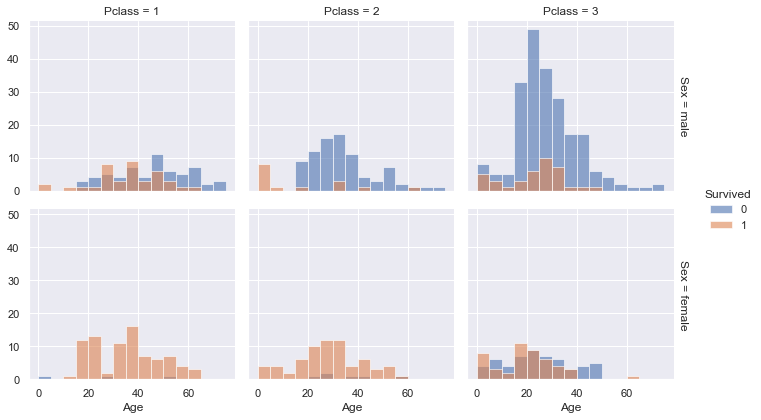

In [85]:
bins = np.arange(0, 80, 5)
g = sns.FacetGrid(df_train, row='Sex', col='Pclass', hue='Survived', margin_titles=True, size=3, aspect=1.1)
g.map(sns.distplot, 'Age', kde=False, bins=bins, hist_kws=dict(alpha=0.6))
g.add_legend()  
plt.show()  

Best chances to survive for male passengers was in Pclass 1 or being below 5 years old.  
Lowest survival rate for female passengers was in Pclass 3 and being older than 40.  
Most passengers were male, in Pclass 3 and between 15-35 years old.

**Disribution of Fare as function of Pclass, Sexand Survived**

In [86]:
df_train['Fare'].max()

512.3292

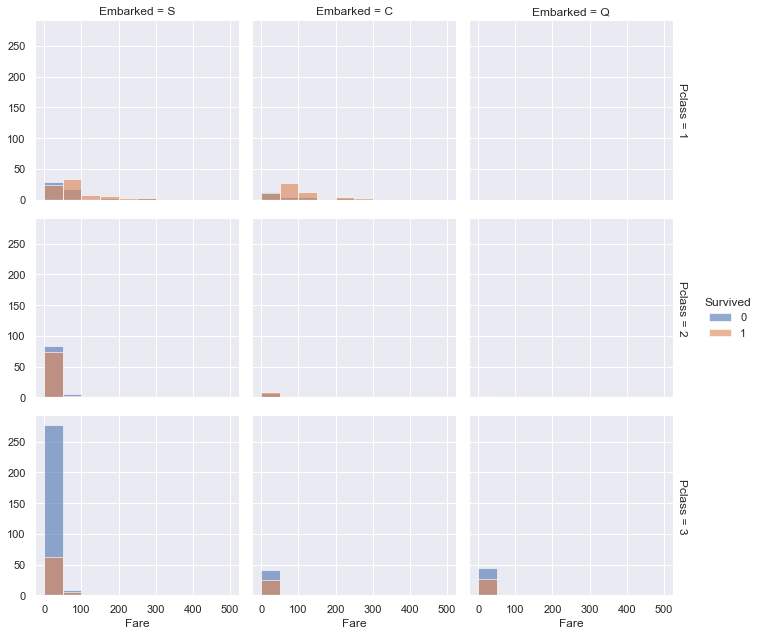

In [93]:
bins = np.arange(0, 550, 50)
g = sns.FacetGrid(df_train, row='Pclass', col='Embarked', hue='Survived', margin_titles=True, size=3, aspect=1.1)
g.map(sns.distplot, 'Fare', kde=False, bins=bins, hist_kws=dict(alpha=0.6))
g.add_legend()  
plt.show()  

### Bar and Box plots

Default mode for seaborn barplots is to plot the mean value for the category.  
Also, the standard deviation is indicated.  
So, if we choose Survived as y-value, we get a plot of the survival rate as function   
of the categories present in the feature chosen as x-value.

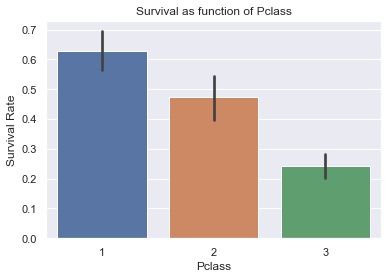

In [94]:
sns.barplot(x='Pclass', y='Survived', data=df_train)
plt.ylabel("Survival Rate")
plt.title("Survival as function of Pclass")
plt.show()

As we know from the first Titanic kernel, survival rate decreses with Pclass.  
The hue parameter lets us see the difference in survival rate for male and female. 

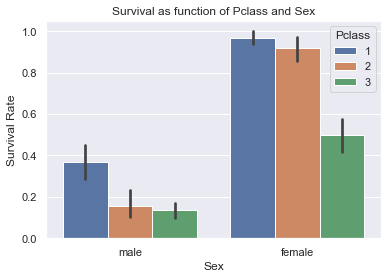

In [47]:
sns.barplot(x='Sex', y='Survived', hue='Pclass', data=df_train)
plt.ylabel("Survival Rate")
plt.title("Survival as function of Pclass and Sex")
plt.show()

In [96]:
male_1class = np.array([1, 1, 0, 1,0, 1])

In [99]:
np.mean(male_1class)

0.6666666666666666

In [98]:
np.mean(male_1class) + np.std(male_1class), np.mean(male_1class) - np.std(male_1class)

(1.1380711874576983, 0.19526214587563495)

Highest survival rate (>0.9) for women in Pclass 1 or 2.  
Lowest survival rate (<0.2) for men in Pclass 3.

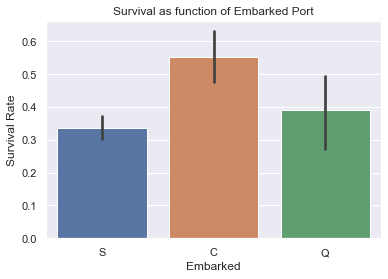

In [100]:
sns.barplot(x='Embarked', y='Survived', data=df_train)
plt.ylabel("Survival Rate")
plt.title("Survival as function of Embarked Port")
plt.show()

Passengers embarked in "S" had the lowest survival rate, those embarked in "C" the highest.  
Again, with hue we see the survival rate as function of Embarked and Pclass.

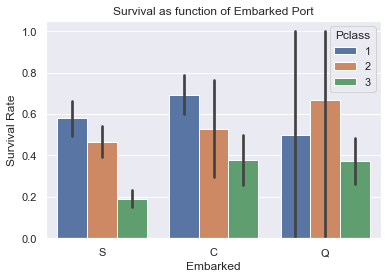

In [101]:
sns.barplot(x='Embarked', y='Survived', hue='Pclass', data=df_train)
plt.ylabel("Survival Rate")
plt.title("Survival as function of Embarked Port")
plt.show()

But survival rate alone is not good beacuse its uncertainty depends on the number of samples.  
We also need to consider the total number (count) of passengers that embarked.

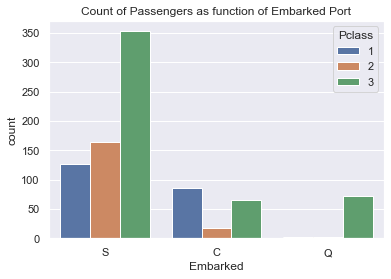

In [102]:
sns.countplot(x='Embarked', hue='Pclass', data=df_train)
plt.title("Count of Passengers as function of Embarked Port")
plt.show()

Passengers embarked in "C" had largest proportion of Pclass 1 tickets.  
Almost all Passengers embarked in "Q" had Pclass 3 tickets.  
For every class, the largest count of Passengers  embarked in "S".

**Boxplot**

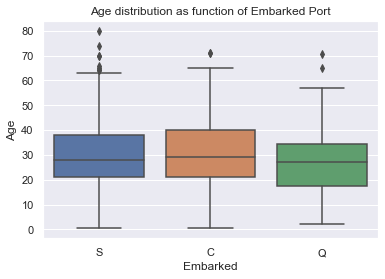

In [103]:
sns.boxplot(x='Embarked', y='Age', data=df_train)
plt.title("Age distribution as function of Embarked Port")
plt.show()

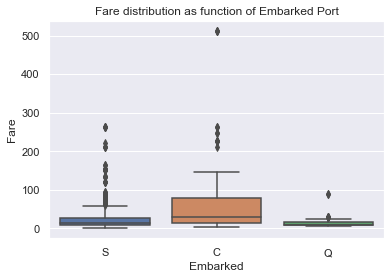

In [104]:
sns.boxplot(x='Embarked', y='Fare', data=df_train)
plt.title("Fare distribution as function of Embarked Port")
plt.show()

### Swarm and Violin plots
Although the following swarm and violin plots show the same data like the countplots or distplots before,  
they can reveal ceratin details that disappear in other plots. However, it takes more time to study these plots in detail.

In [105]:
cm_surv = ["darkgrey" , "lightgreen"]

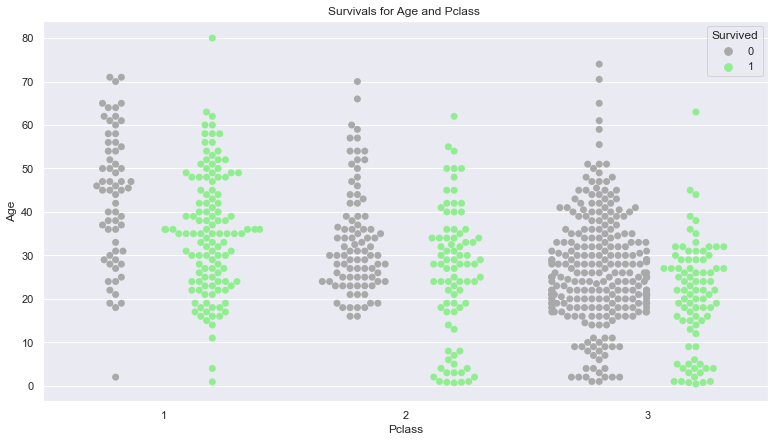

In [106]:
fig, ax = plt.subplots(figsize=(13,7))
sns.swarmplot(x='Pclass', y='Age', hue='Survived', split=True, data=df_train , palette=cm_surv, size=7, ax=ax)
plt.title('Survivals for Age and Pclass ')
plt.show()

Here, the high survival rate for kids in Pclass 2 is easily observed.  
Also, it becomes more obvious that for passengers older than 40 the best chance to survive is in Pclass 1,  
and smallest chance in Pclass 3   

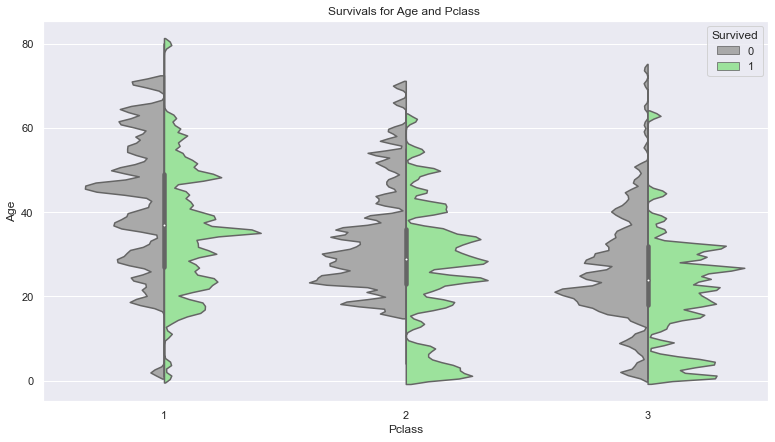

In [107]:
fig, ax = plt.subplots(figsize=(13,7))
sns.violinplot(x="Pclass", y="Age", hue='Survived', data=df_train, split=True, bw=0.05 , palette=cm_surv, ax=ax)
plt.title('Survivals for Age and Pclass ')
plt.show()

This violinplot shows exactly the same info like the swarmplot before.

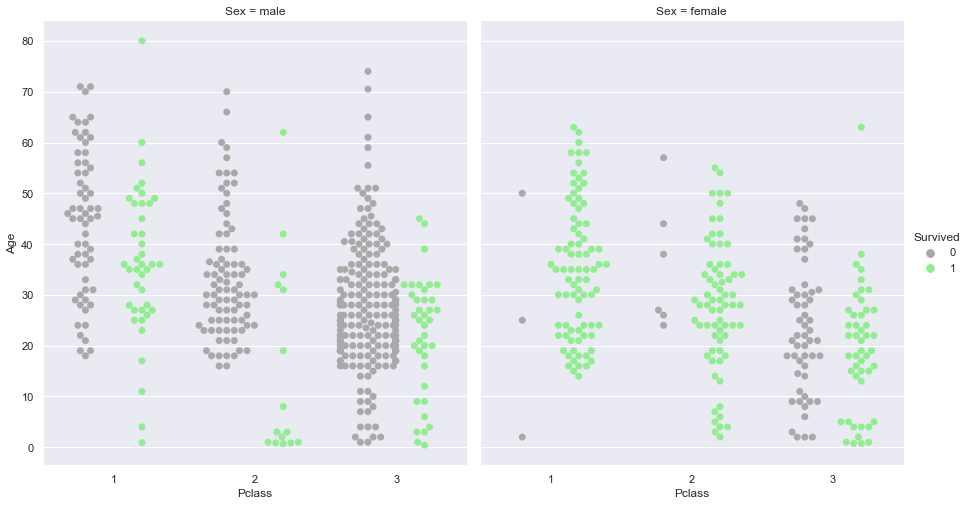

In [56]:
g = sns.factorplot(x="Pclass", y="Age", hue="Survived", col="Sex", 
                   data=df_train, kind="swarm", split=True, palette=cm_surv, size=7, aspect=.9, s=7)

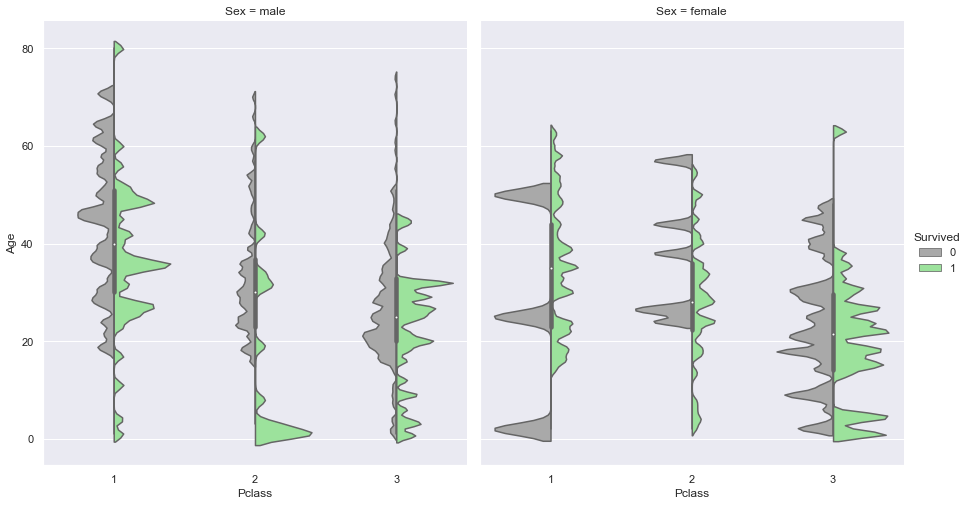

In [57]:
g = sns.factorplot(x="Pclass", y="Age", hue="Survived", col="Sex", 
                   data=df_train, kind="violin", split=True, bw=0.05, palette=cm_surv, size=7, aspect=.9, s=7)

# Part 2: Data Wrangling and Feature Engineering

## Feature Engineering
**New Features: 'FamilySize'  ,  'Alone' , 'NameLen' and 'Title'**

In [108]:
for df in [df_train, df_test] :
    
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    df['Alone'] = 0
    df.loc[(df.FamilySize==1),'Alone'] = 1
    
    df['NameLen'] = df.Name.apply(lambda x : len(x)) 
    df['NameLenBin']=np.nan
    for i in range(20,0,-1):
        df.loc[ df['NameLen'] <= i*5, 'NameLenBin'] = i  # it means that 5*(i-1) < len(Name) <= 5*i
    
    
    df['Title']=0 
    df['Title']=df.Name.str.extract(r'([A-Za-z]+)\.') #lets extract the Salutations
    # Lady. Washington
    df['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                    ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [109]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize', 'Alone',
       'NameLen', 'NameLenBin', 'Title'],
      dtype='object')

In [110]:
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Alone,NameLen,NameLenBin,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,23,5.0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,51,11.0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,22,5.0,Miss


### New Feature: NameLenBin

In [111]:
print(df_train[['NameLen' , 'NameLenBin']].head(10))

   NameLen  NameLenBin
0       23         5.0
1       51        11.0
2       22         5.0
3       44         9.0
4       24         5.0
5       16         4.0
6       23         5.0
7       30         6.0
8       49        10.0
9       35         7.0


In [117]:
grps_namelenbin_survrate = df_train.groupby(['NameLenBin'])['Survived'].mean().to_frame()
# SELECT AVG(Survived) FROM df_train GROUP BY NameLenBin
grps_namelenbin_survrate

,Survived
NameLenBin,
3.0,0.227273
4.0,0.230769
5.0,0.325581
6.0,0.364929
7.0,0.522727
8.0,0.477273
9.0,0.800000
10.0,0.800000
11.0,0.812500


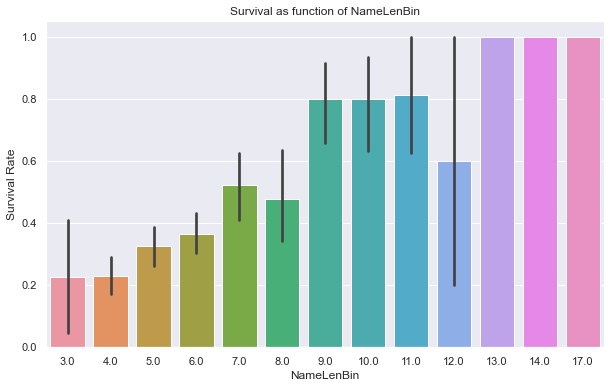

In [118]:
plt.subplots(figsize=(10,6))
sns.barplot(x='NameLenBin' , y='Survived', data = df_train)
plt.ylabel("Survival Rate")
plt.title("Survival as function of NameLenBin")
plt.show()

**Looks like there is very strong correlation of Survival rate and Name length**

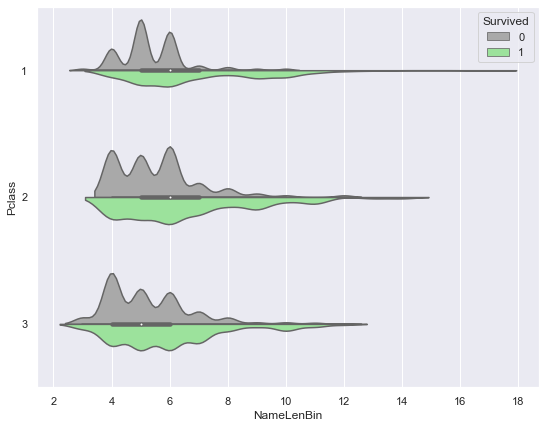

In [119]:
fig, ax = plt.subplots(figsize=(9,7))
sns.violinplot(x="NameLenBin", y="Pclass", data=df_train, hue='Survived', split=True, 
               orient="h", bw=0.2 , palette=cm_surv, ax=ax)
plt.show()

**Chance to survive increases with length of name for all Passenger classes**

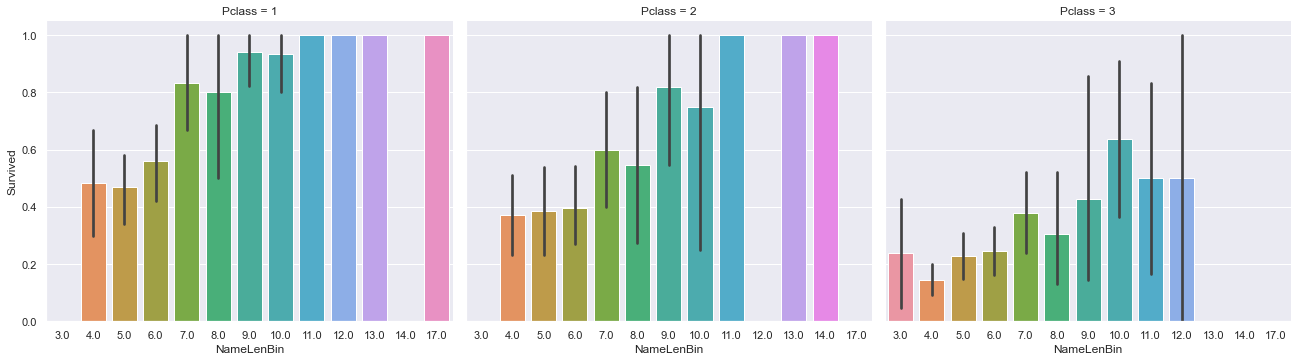

In [120]:
g = sns.factorplot(x="NameLenBin", y="Survived", col="Pclass", data=df_train, kind="bar", size=5, aspect=1.2)

**Increase of survival rate with length of name most important for male passengers**

### New Feature: Title

In [121]:
grps_title_survrate = df_train.groupby(['Title'])['Survived'].mean().to_frame()
grps_title_survrate

,Survived
Title,
Master,0.575000
Miss,0.704301
Mr,0.162571
Mrs,0.795276
Other,0.111111


In [122]:
grps_title_survrate['Title'] = grps_title_survrate.index

In [123]:
grps_title_survrate

,Survived,Title
Title,,
Master,0.575000,Master
Miss,0.704301,Miss
Mr,0.162571,Mr
Mrs,0.795276,Mrs
Other,0.111111,Other


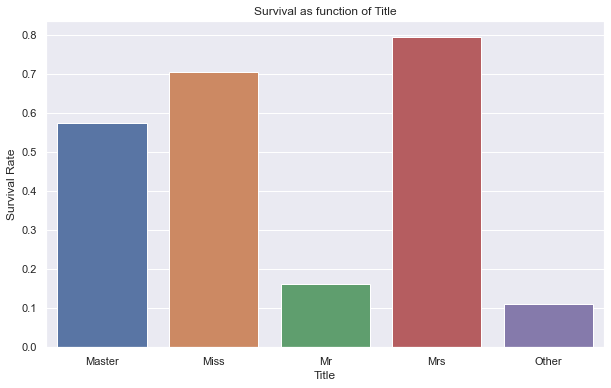

In [124]:
plt.subplots(figsize=(10,6))
sns.barplot(x='Title' , y='Survived' , data = grps_title_survrate)
plt.ylabel("Survival Rate")
plt.title("Survival as function of Title")
plt.show()

### New Feature: Family size

In [126]:
pd.crosstab(df_train.FamilySize, df_train.Survived)\
            .apply(lambda r: r/r.sum(), axis=1).style.background_gradient(cmap='summer_r')

Survived,0,1
FamilySize,,
1,0.696462,0.303538
2,0.447205,0.552795
3,0.421569,0.578431
4,0.275862,0.724138
5,0.800000,0.200000
6,0.863636,0.136364
7,0.666667,0.333333
8,1.000000,0.000000
11,1.000000,0.000000


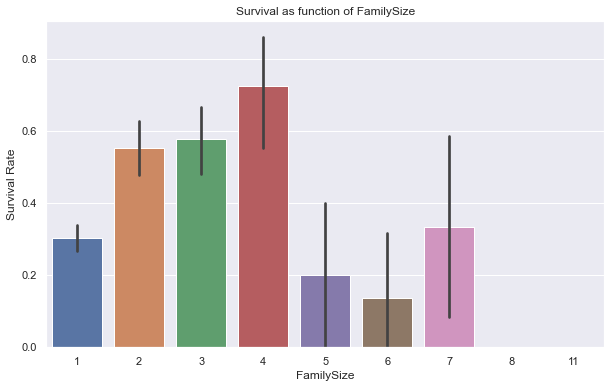

In [127]:
plt.subplots(figsize=(10,6))
sns.barplot(x='FamilySize' , y='Survived' , data=df_train)
plt.ylabel("Survival Rate")
plt.title("Survival as function of FamilySize")
plt.show()

## Data Wrangling

In [128]:
np.nan * 10

nan

**Fill NaN with mean or mode**

In [129]:
for df in [df_train, df_test]:

    # Title
    df['Title'] = df['Title'].fillna(df['Title'].mode().iloc[0])

    # Age: use Title to fill missing values
    df.loc[(df.Age.isnull())&(df.Title=='Mr'),'Age']= df.Age[df.Title=="Mr"].mean()
    df.loc[(df.Age.isnull())&(df.Title=='Mrs'),'Age']= df.Age[df.Title=="Mrs"].mean()
    df.loc[(df.Age.isnull())&(df.Title=='Master'),'Age']= df.Age[df.Title=="Master"].mean()
    df.loc[(df.Age.isnull())&(df.Title=='Miss'),'Age']= df.Age[df.Title=="Miss"].mean()
    df.loc[(df.Age.isnull())&(df.Title=='Other'),'Age']= df.Age[df.Title=="Other"].mean()
    df = df.drop('Name', axis=1)

In [131]:
# Embarked
df_train['Embarked'] = df_train['Embarked'].fillna(df_train['Embarked'].mode().iloc[0])
df_test['Embarked'] = df_test['Embarked'].fillna(df_train['Embarked'].mode().iloc[0])

# Fare
df_train['Fare'] = df_train['Fare'].fillna(df_train['Fare'].mean())
df_test['Fare'] = df_test['Fare'].fillna(df_train['Fare'].mean())

### Bining for Age and Fare, convert Title to numerical

In [132]:
for df in [df_train, df_test]:
    
    df['Age_bin']=np.nan
    for i in range(8,0,-1):
        df.loc[ df['Age'] <= i*10, 'Age_bin'] = i  # age_bin = i <=> (i - 1) * 10 < age < 10 * i 
        
    df['Fare_bin']=np.nan
    for i in range(12,0,-1):
        df.loc[ df['Fare'] <= i*50, 'Fare_bin'] = i        
    
    # convert Title to numerical
    df['Title'] = df['Title'].map( {'Other':0, 'Mr': 1, 'Master':2, 'Miss': 3, 'Mrs': 4 } )
    # fill na with maximum frequency mode
    df['Title'] = df['Title'].fillna(df['Title'].mode().iloc[0])
    df['Title'] = df['Title'].astype(int)        

In [138]:
df_train_ml = df_train.copy()
df_test_ml = df_test.copy()

passenger_id = df_test_ml['PassengerId']

**double-check for missing values**

In [139]:
df_train_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  FamilySize   891 non-null    int64  
 13  Alone        891 non-null    int64  
 14  NameLen      891 non-null    int64  
 15  NameLenBin   891 non-null    float64
 16  Title        891 non-null    int64  
 17  Age_bin      891 non-null    float64
 18  Fare_bin     891 non-null    float64
dtypes: float

In [140]:
df_test_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  FamilySize   418 non-null    int64  
 12  Alone        418 non-null    int64  
 13  NameLen      418 non-null    int64  
 14  NameLenBin   418 non-null    float64
 15  Title        418 non-null    int64  
 16  Age_bin      418 non-null    float64
 17  Fare_bin     418 non-null    float64
dtypes: float64(5), int64(8), object(5)
memory usage: 5

**convert categorical to numerical : get_dummies**

In [141]:
df_train_ml = pd.get_dummies(df_train_ml, columns=['Sex', 'Embarked', 'Pclass', "Title"], drop_first=True)
df_test_ml = pd.get_dummies(df_test_ml, columns=['Sex', 'Embarked', 'Pclass', "Title"], drop_first=True)

df_train_ml.drop(['PassengerId','Name','Ticket', 'Cabin', 'Age', 'Fare_bin'], axis=1,inplace=True)
df_test_ml.drop(['PassengerId','Name','Ticket', 'Cabin', 'Age', 'Fare_bin'], axis=1,inplace=True)

In [142]:
df_train_ml.dropna(inplace=True)

In [143]:
for df in [df_train_ml, df_test_ml]:
    df.drop(['NameLen'], axis=1, inplace=True)

    df.drop(['SibSp'], axis=1, inplace=True)
    df.drop(['Parch'], axis=1, inplace=True)
    df.drop(['Alone'], axis=1, inplace=True)

In [144]:
df_train_ml.head()

,Survived,Fare,FamilySize,NameLenBin,Age_bin,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Title_1,Title_2,Title_3,Title_4
0,0,7.2500,2,5.0,3.0,1,0,1,0,1,1,0,0,0
1,1,71.2833,2,11.0,4.0,0,0,0,0,0,0,0,0,1
2,1,7.9250,1,5.0,3.0,0,0,1,0,1,0,0,1,0
3,1,53.1000,2,9.0,4.0,0,0,1,0,0,0,0,0,1
4,0,8.0500,1,5.0,4.0,1,0,1,0,1,1,0,0,0


In [145]:
df_test_ml.fillna(df_test_ml.mean(), inplace=True)
df_test_ml.head()

,Fare,FamilySize,NameLenBin,Age_bin,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Title_1,Title_2,Title_3,Title_4
0,7.8292,1,4.0,4.0,1,1,0,0,1,1,0,0,0
1,7.0000,2,7.0,5.0,0,0,1,0,1,0,0,0,1
2,9.6875,1,5.0,7.0,1,1,0,1,0,1,0,0,0
3,8.6625,1,4.0,3.0,1,0,1,0,1,1,0,0,0
4,12.2875,3,9.0,3.0,0,0,1,0,1,0,0,0,1


### Standard Scaler

In [146]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# for df_train_ml
scaler.fit(df_train_ml.drop(['Survived'],axis=1))
scaled_features = scaler.transform(df_train_ml.drop(['Survived'],axis=1))
df_train_ml_sc = pd.DataFrame(scaled_features) # columns=df_train_ml.columns[1::])

# for df_test_ml
df_test_ml.fillna(df_test_ml.mean(), inplace=True)
#scaler.fit(df_test_ml)
scaled_features = scaler.transform(df_test_ml)
df_test_ml_sc = pd.DataFrame(scaled_features) # , columns=df_test_ml.columns)

In [147]:
df_train_ml_sc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.502445,0.059160,-0.422786,-0.363116,0.737695,-0.307562,0.615838,-0.510152,0.902587,0.827230,-0.216803,-0.513644,-0.407714
1,0.786845,0.059160,2.751669,0.385810,-1.355574,-0.307562,-1.623803,-0.510152,-1.107926,-1.208853,-0.216803,-0.513644,2.452702
2,-0.488854,-0.560975,-0.422786,-0.363116,-1.355574,-0.307562,0.615838,-0.510152,0.902587,-1.208853,-0.216803,1.946875,-0.407714
3,0.420730,0.059160,1.693517,0.385810,-1.355574,-0.307562,0.615838,-0.510152,-1.107926,-1.208853,-0.216803,-0.513644,2.452702
4,-0.486337,-0.560975,-0.422786,0.385810,0.737695,-0.307562,0.615838,-0.510152,0.902587,0.827230,-0.216803,-0.513644,-0.407714


In [148]:
df_test_ml_sc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.490783,-0.560975,-0.951861,0.385810,0.737695,3.251373,-1.623803,-0.510152,0.902587,0.827230,-0.216803,-0.513644,-0.407714
1,-0.507479,0.059160,0.635366,1.134737,-1.355574,-0.307562,0.615838,-0.510152,0.902587,-1.208853,-0.216803,-0.513644,2.452702
2,-0.453367,-0.560975,-0.422786,2.632589,0.737695,3.251373,-1.623803,1.960202,-1.107926,0.827230,-0.216803,-0.513644,-0.407714
3,-0.474005,-0.560975,-0.951861,-0.363116,0.737695,-0.307562,0.615838,-0.510152,0.902587,0.827230,-0.216803,-0.513644,-0.407714
4,-0.401017,0.679295,1.693517,-0.363116,-1.355574,-0.307562,0.615838,-0.510152,0.902587,-1.208853,-0.216803,-0.513644,2.452702


In [149]:
df_train_ml.head()

,Survived,Fare,FamilySize,NameLenBin,Age_bin,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Title_1,Title_2,Title_3,Title_4
0,0,7.2500,2,5.0,3.0,1,0,1,0,1,1,0,0,0
1,1,71.2833,2,11.0,4.0,0,0,0,0,0,0,0,0,1
2,1,7.9250,1,5.0,3.0,0,0,1,0,1,0,0,1,0
3,1,53.1000,2,9.0,4.0,0,0,1,0,0,0,0,0,1
4,0,8.0500,1,5.0,4.0,1,0,1,0,1,1,0,0,0


In [150]:
X = df_train_ml.drop('Survived', axis=1)
y = df_train_ml['Survived']
X_test = df_test_ml

X_sc = df_train_ml_sc
y_sc = df_train_ml['Survived']
X_test_sc = df_test_ml_sc

# Part 3: Optimization of Classifier parameters, Boosting, Voting and Stacking

In [151]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import tree


from sklearn.metrics import accuracy_score


### Review: k fold cross validation  
just a short review of this technique that we already studied in the first kernel

In [152]:
from sklearn.model_selection import cross_val_score

### SVC, features not scaled  
Support Vector Machine Classifier

In [153]:
svc = SVC(gamma = 0.01, C = 100)
scores_svc = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
print(scores_svc)
print(scores_svc.mean())

[0.77777778 0.78651685 0.75280899 0.79775281 0.82022472 0.79775281
 0.84269663 0.78651685 0.86516854 0.83146067]
0.8058676654182271


### SVC, features scaled  

In [154]:
svc = SVC(gamma = 0.01, C = 100)
scores_svc_sc = cross_val_score(svc, X_sc, y_sc, cv=10, scoring='accuracy')
print(scores_svc_sc)
print(scores_svc_sc.mean())

[0.82222222 0.82022472 0.78651685 0.88764045 0.85393258 0.80898876
 0.80898876 0.76404494 0.86516854 0.85393258]
0.8271660424469414


### RFC, features not scaled  

In [155]:
rfc = RandomForestClassifier(max_depth=5, max_features=6)
scores_rfc = cross_val_score(rfc, X, y, cv=10, scoring='accuracy')
print(scores_rfc)
print(scores_rfc.mean())

[0.81111111 0.87640449 0.76404494 0.87640449 0.84269663 0.79775281
 0.83146067 0.7752809  0.87640449 0.80898876]
0.8260549313358302


## Hyperparameter tuning with RandomizedSearchCV and GridSearchCV

**RandomizedSearchCV  and GridSearchCV apply k fold cross validation on a chosen set of parameters**
**and then find the parameters that give the best performance.**  
For GridSearchCV, all possible combinations of the specified parameter values are tried out, resulting in a parameter grid.  
For RandomizedSearchCV, a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.

In [156]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

**In the following we apply GridSearchCV and RandomizedSearchCV for these Classification models:**  
**KNN, Decision Tree, Random Forest, SVC**

### SVC : RandomizedSearchCV

In [76]:
model = SVC()
param_grid = {'C':uniform(0.1, 5000), 'gamma':uniform(0.0001, 1) }
rand_SVC = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100)
rand_SVC.fit(X_sc,y_sc)
score_rand_SVC = get_best_score(rand_SVC)

0.8125792480070302
{'C': 634.4624336286086, 'gamma': 0.020803824751132415}
SVC(C=634.4624336286086, gamma=0.020803824751132415)


### SVC : GridSearchCV

In [77]:
param_grid = {'C': [0.1,10, 100, 1000,5000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}
svc_grid = GridSearchCV(SVC(), param_grid, cv=10, refit=True, verbose=1)
svc_grid.fit(X_sc,y_sc)
sc_svc = get_best_score(svc_grid)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
0.8338951310861423
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.001)


**submission for svc**

In [78]:
pred_all_svc = svc_grid.predict(X_test_sc)

sub_svc = pd.DataFrame()
sub_svc['PassengerId'] = df_test['PassengerId']
sub_svc['Survived'] = pred_all_svc
sub_svc.to_csv('svc.csv',index=False)

### KNN

In [ ]:
knn = KNeighborsClassifier()
leaf_range = list(range(3, 15, 1))
k_range = list(range(1, 15, 1))
weight_options = ['uniform', 'distance']
param_grid = dict(leaf_size=leaf_range, n_neighbors=k_range, weights=weight_options)
print(param_grid)

knn_grid = GridSearchCV(knn, param_grid, cv=10, verbose=1, scoring='accuracy')
knn_grid.fit(X, y)

sc_knn = get_best_score(knn_grid)

**submission for knn**

In [ ]:
pred_all_knn = knn_grid.predict(X_test)

sub_knn = pd.DataFrame()
sub_knn['PassengerId'] = df_test['PassengerId']
sub_knn['Survived'] = pred_all_knn
sub_knn.to_csv('knn.csv',index=False)

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()

param_grid = {'min_samples_split': [4,7,10,12]}
dtree_grid = GridSearchCV(dtree, param_grid, cv=10, refit=True, verbose=1)
dtree_grid.fit(X_sc,y_sc)

print(dtree_grid.best_score_)
print(dtree_grid.best_params_)
print(dtree_grid.best_estimator_)

**submission for decision tree**

In [ ]:
pred_all_dtree = dtree_grid.predict(X_test_sc)

sub_dtree = pd.DataFrame()
sub_dtree['PassengerId'] = df_test['PassengerId']
sub_dtree['Survived'] = pred_all_dtree
sub_dtree.to_csv('dtree.csv',index=False)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

param_grid = {'max_depth': [3, 5, 6, 7, 8], 'max_features': [6,7,8,9,10],  
              'min_samples_split': [5, 6, 7, 8]}

rf_grid = GridSearchCV(rfc, param_grid, cv=10, refit=True, verbose=1)
rf_grid.fit(X_sc,y_sc)
sc_rf = get_best_score(rf_grid)

In [ ]:
plot_feature_importances(rf_grid, X.columns)

**submission for random forest**

In [ ]:
pred_all_rf = rf_grid.predict(X_test_sc)

sub_rf = pd.DataFrame()
sub_rf['PassengerId'] = df_test['PassengerId']
sub_rf['Survived'] = pred_all_rf
sub_rf.to_csv('rf.csv',index=False)

### ExtraTreesClassifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
extr = ExtraTreesClassifier()

param_grid = {'max_depth': [6,7,8,9], 'max_features': [7,8,9,10],  
              'n_estimators': [50, 100, 200]}

extr_grid = GridSearchCV(extr, param_grid, cv=10, refit=True, verbose=1)
extr_grid.fit(X_sc,y_sc)
sc_extr = get_best_score(extr_grid)

In [ ]:
plot_feature_importances(extr_grid, X.columns)

**submission for ExtraTreesClassifier**

In [ ]:
pred_all_extr = extr_grid.predict(X_test_sc)

sub_extr = pd.DataFrame()
sub_extr['PassengerId'] = df_test['PassengerId']
sub_extr['Survived'] = pred_all_extr
sub_extr.to_csv('extr.csv',index=False)

### Gradient Boost Decision Tree GBDT 


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()

param_grid = {'n_estimators': [50, 100], 
              'min_samples_split': [3, 4, 5, 6, 7],
              'max_depth': [3, 4, 5, 6]}
gbc_grid = GridSearchCV(gbc, param_grid, cv=10, refit=True, verbose=1)
gbc_grid.fit(X_sc,y_sc)
sc_gbc = get_best_score(gbc_grid)

In [ ]:
plot_feature_importances(gbc_grid, X.columns)

**submission for GradientBoostingClassifier**

In [ ]:
pred_all_gbc = gbc_grid.predict(X_test_sc)

sub_gbc = pd.DataFrame()
sub_gbc['PassengerId'] = df_test['PassengerId']
sub_gbc['Survived'] = pred_all_gbc
sub_gbc.to_csv('gbc.csv',index=False)

### eXtreme Gradient Boosting - XGBoost

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
param_grid = {'max_depth': [5,6,7,8], 'gamma': [1, 2, 4], 'learning_rate': [0.1, 0.2, 0.3, 0.5]}

with ignore_warnings(category=DeprecationWarning):
    xgb_grid = GridSearchCV(xgb, param_grid, cv=10, refit=True, verbose=1)
    xgb_grid.fit(X_sc,y_sc)
    sc_xgb = get_best_score(xgb_grid)

In [ ]:
plot_feature_importances(xgb_grid, X.columns)

In [ ]:
with ignore_warnings(category=DeprecationWarning):
    pred_all_xgb = xgb_grid.predict(X_test_sc)

sub_xgb = pd.DataFrame()
sub_xgb['PassengerId'] = df_test['PassengerId']
sub_xgb['Survived'] = pred_all_xgb
sub_xgb.to_csv('xgb.csv',index=False)

### Ada Boost  

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()

param_grid = {'n_estimators': [30, 50, 100], 'learning_rate': [0.08, 0.1, 0.2]}
ada_grid = GridSearchCV(ada, param_grid, cv=10, refit=True, verbose=1)
ada_grid.fit(X_sc,y_sc)
sc_ada = get_best_score(ada_grid)

pred_all_ada = ada_grid.predict(X_test_sc)

In [ ]:
plot_feature_importances(ada_grid, X.columns)

In [ ]:
sub_ada = pd.DataFrame()
sub_ada['PassengerId'] = df_test['PassengerId']
sub_ada['Survived'] = pred_all_ada
sub_ada.to_csv('ada.csv',index=False)

### CatBoost
library for gradient boosting on decision trees with categorical features support

In [80]:
from catboost import CatBoostClassifier
cat=CatBoostClassifier()

param_grid = {'iterations': [100, 150], 'learning_rate': [0.3, 0.4, 0.5], 'loss_function' : ['Logloss']}

cat_grid = GridSearchCV(cat, param_grid, cv=10, refit=True, verbose=1)
cat_grid.fit(X_sc,y_sc, verbose=False)
sc_cat = get_best_score(cat_grid)

pred_all_cat = cat_grid.predict(X_test_sc)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
0.8384269662921348
{'iterations': 100, 'learning_rate': 0.3, 'loss_function': 'Logloss'}


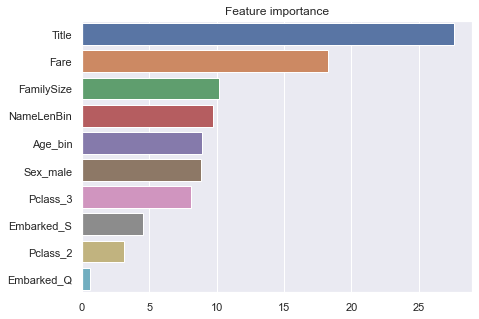

In [81]:
plot_feature_importances(cat_grid, X.columns)

In [157]:
from sklearn.feature_selection import SelectFpr

In [ ]:
# 2 ** d

In [ ]:
sub_cat = pd.DataFrame()
sub_cat['PassengerId'] = df_test['PassengerId']
sub_cat['Survived'] = pred_all_cat
sub_cat['Survived'] = sub_cat['Survived'].astype(int)
sub_cat.to_csv('cat.csv',index=False)

### lightgbm LGBM

In [ ]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier(silent=False)
param_grid = {"max_depth": [8,10,15], "learning_rate" : [0.008,0.01,0.012], 
              "num_leaves": [80,100,120], "n_estimators": [200,250]  }
lgbm_grid = GridSearchCV(lgbm, param_grid, cv=10, refit=True, verbose=1)
lgbm_grid.fit(X_sc,y_sc, verbose=True)
sc_lgbm = get_best_score(lgbm_grid)

pred_all_lgbm = lgbm_grid.predict(X_test_sc)

In [ ]:
plot_feature_importances(lgbm_grid, X.columns)

In [ ]:
sub_lgbm = pd.DataFrame()
sub_lgbm['PassengerId'] = df_test['PassengerId']
sub_lgbm['Survived'] = pred_all_lgbm
sub_lgbm.to_csv('lgbm.csv',index=False)

### VotingClassifier

In [ ]:
from sklearn.ensemble import VotingClassifier

### First Voting  
for the first voting ensemble I use three simple models (LR, RF, GNB)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')

params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200],}

with ignore_warnings(category=DeprecationWarning):
    votingclf_grid = GridSearchCV(estimator=eclf, param_grid=params, cv=10)
    votingclf_grid.fit(X_sc,y_sc)
    sc_vot1 = get_best_score(votingclf_grid)

### Second Voting

for the 2nd voting ensemble I use the three models (together with the optimal parameters found by GridSearchCV)  
that had the best test score based on the cross validations above 

In [ ]:
clf4 = GradientBoostingClassifier()
clf5 = SVC()
clf6 = RandomForestClassifier()

eclf_2 = VotingClassifier(estimators=[('gbdt', clf4), 
                                      ('svc', clf5), 
                                      ('rf', clf6)], voting='soft')

params = {'gbdt__n_estimators': [50], 'gbdt__min_samples_split': [3],
          'svc__C': [10, 100] , 'svc__gamma': [0.1,0.01,0.001] , 'svc__kernel': ['rbf'] , 'svc__probability': [True],  
          'rf__max_depth': [7], 'rf__max_features': [2,3], 'rf__min_samples_split': [3] } 

with ignore_warnings(category=DeprecationWarning):
    votingclf_grid_2 = GridSearchCV(estimator=eclf_2, param_grid=params, cv=10)
    votingclf_grid_2.fit(X_sc,y_sc)
    sc_vot2_cv = get_best_score(votingclf_grid_2)

In [ ]:
with ignore_warnings(category=DeprecationWarning):    
    pred_all_vot2 = votingclf_grid_2.predict(X_test_sc)

sub_vot2 = pd.DataFrame()
sub_vot2['PassengerId'] = df_test['PassengerId']
sub_vot2['Survived'] = pred_all_vot2
sub_vot2.to_csv('vot2.csv',index=False)

### StackingClassifier

In [ ]:
from mlxtend.classifier import StackingClassifier

In [ ]:
# Initializing models
clf1 = xgb_grid.best_estimator_
clf2 = gbc_grid.best_estimator_
clf3 = rf_grid.best_estimator_
clf4 = svc_grid.best_estimator_

lr = LogisticRegression()
st_clf = StackingClassifier(classifiers=[clf1, clf1, clf2, clf3, clf4], meta_classifier=lr)

params = {'meta_classifier__C': [0.1,1.0,5.0,10.0] ,
          #'use_probas': [True] ,
          #'average_probas': [True] ,
          'use_features_in_secondary' : [True, False]
         }
with ignore_warnings(category=DeprecationWarning):
    st_clf_grid = GridSearchCV(estimator=st_clf, param_grid=params, cv=5, refit=True)
    st_clf_grid.fit(X_sc, y_sc)
    sc_st_clf = get_best_score(st_clf_grid)

In [ ]:
with ignore_warnings(category=DeprecationWarning):    
    pred_all_stack = st_clf_grid.predict(X_test_sc)

sub_stack = pd.DataFrame()
sub_stack['PassengerId'] = df_test['PassengerId']
sub_stack['Survived'] = pred_all_stack
sub_stack.to_csv('stack_clf.csv',index=False)

### Comparison plot for best models

### scores from GridSearchCV

In [ ]:
list_scores = [sc_knn, sc_rf, sc_extr, sc_svc, sc_gbc, sc_xgb, 
               sc_ada, sc_cat, sc_lgbm, sc_vot2_cv, sc_st_clf]

list_classifiers = ['KNN','RF','EXTR','SVC','GBC','XGB',
                    'ADA','CAT','LGBM','VOT2','STACK']

### submission scores

In [ ]:
score_subm_svc   = 0.80861
score_subm_vot2  = 0.78947
score_subm_ada   = 0.78468
score_subm_lgbm  = 0.78468
score_subm_rf    = 0.77990
score_subm_xgb   = 0.77033
score_subm_dtree = 0.76076
score_subm_extr  = 0.76076
score_subm_gbc   = 0.74641
score_subm_cat   = 0.74162
score_subm_knn   = 0.69856

score_subm_stack = 0.76076

In [ ]:
subm_scores = [score_subm_knn, score_subm_rf, score_subm_extr, score_subm_svc, 
               score_subm_gbc, score_subm_xgb, score_subm_ada, score_subm_cat, 
               score_subm_lgbm, score_subm_vot2, score_subm_stack]

In [ ]:
trace1 = go.Scatter(x = list_classifiers, y = list_scores,
                   name="Validation", text = list_classifiers)
trace2 = go.Scatter(x = list_classifiers, y = subm_scores,
                   name="Submission", text = list_classifiers)

data = [trace1, trace2]

layout = dict(title = "Validation and Submission Scores", 
              xaxis=dict(ticklen=10, zeroline= False),
              yaxis=dict(title = "Accuracy", side='left', ticklen=10,),                                  
              legend=dict(orientation="v", x=1.05, y=1.0),
              autosize=False, width=750, height=500,
              )

fig = dict(data = data, layout = layout)
iplot(fig)

### Correlation of prediction results

In [ ]:
predictions = {'KNN': pred_all_knn, 'RF': pred_all_rf, 'EXTR': pred_all_extr, 
               'SVC': pred_all_svc, 'GBC': pred_all_gbc, 'XGB': pred_all_xgb, 
               'ADA': pred_all_ada, 'CAT': pred_all_cat, 'LGBM': pred_all_lgbm, 
               'VOT2': pred_all_vot2, 'STACK': pred_all_stack}
df_predictions = pd.DataFrame(data=predictions) 
df_predictions.corr()

In [ ]:
plt.figure(figsize=(9, 9))
sns.set(font_scale=1.25)
sns.heatmap(df_predictions.corr(), linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=df_predictions.columns , xticklabels=df_predictions.columns
            )
plt.yticks(rotation=0)
plt.show()

### Compare feature importances

In [ ]:
imp_rf   = pd.Series(data = rf_grid.best_estimator_.feature_importances_, index=X.columns)
imp_extr = pd.Series(data = extr_grid.best_estimator_.feature_importances_, index=X.columns)
imp_gbc = pd.Series(data = gbc_grid.best_estimator_.feature_importances_, index=X.columns)
imp_xgb = pd.Series(data = xgb_grid.best_estimator_.feature_importances_, index=X.columns)
imp_ada = pd.Series(data = ada_grid.best_estimator_.feature_importances_, index=X.columns)
imp_cat = pd.Series(data = cat_grid.best_estimator_.feature_importances_ / 100, index=X.columns)
imp_lgbm = pd.Series(data = lgbm_grid.best_estimator_.feature_importances_ / 10000, index=X.columns)
imp_lgbm /= imp_lgbm.sum()

In [ ]:
models=['RF', 'EXTR', 'GBC', 'XGB', 'ADA', 'CAT', 'LGBM']

fig = go.Figure(data=[
    go.Bar(name=models[0],  x=imp_rf.index,   y=imp_rf.values),
    go.Bar(name=models[1],  x=imp_extr.index, y=imp_extr.values),
    go.Bar(name=models[2],  x=imp_gbc.index,  y=imp_gbc.values),   
    go.Bar(name=models[3],  x=imp_xgb.index,  y=imp_xgb.values),    
    go.Bar(name=models[4],  x=imp_ada.index,  y=imp_ada.values),        
    go.Bar(name=models[5],  x=imp_cat.index,  y=imp_cat.values),  
    go.Bar(name=models[6],  x=imp_lgbm.index, y=imp_lgbm.values),  
])

fig.update_layout(barmode='group')
fig.update_layout(title=go.layout.Title(
                  text="Feature importances for Ensemble models",
                  xref="paper",
                  x=0.5))
fig.show()

### **Conclusion**

* With this kernel we studied EDA with **Seaborn** including some unusual plots like violin and swarm.   
* Based on the EDA we filled missing values according to related features and developed new features (**Feature Engineering**) to improve model performance.  
* In Part 3 we learned basics of applying **ensemble models** for classification like **Boosting**, **Stacking** and **Voting**.   
* For this we applied libraries like: **sklearn, mlxtend, lightgbm, catboost, xgboost**

**This is my second notebook for the Titanic classification competition.**

If you are new to Machine Learning, have a look at  **[my first Titanic notebook](https://www.kaggle.com/dejavu23/titanic-survival-for-beginners-eda-to-ml)** where  I studied the  
basics of EDA with Pandas and Matplotlib and how to do Classification with the scikit-learn library.  